# Power Generator Characterization

First we load the on-site power generator recording so we can characterize it.

Data can be download from: https://doi.org/10.5281/zenodo.14803434

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [5]:
from scipy.io import wavfile
import warnings
# Suppress the specific WavFileWarning
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.io.wavfile")

samplerate, data = wavfile.read('C:/Users/Maximiliano/Desktop/Antártida PAPER/generador_foreground.wav') #path for the file containing the on-site generator recording

C:\Users\Maximiliano\AppData\Local\Temp\ipykernel_3800\222584650.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read('C:/Users/Maximiliano/Desktop/Antártida PAPER/generador_foreground.wav') #path for the file containing the on-site generator recording


We split the signal into N different intervals and we compute the FFT for each interval. then we average all the spectrums computed for the
different intervals. 

In [7]:
from scipy.fft import fft
def promedio_espectros(data,samplerate,N): #N: the amount of intervals in which the signal is splited
    L=len(data)
    count = 0
    L_intervalo = round(L // N)
    FFT_inter = []

    for ii in range(N):
        vect = data[count * L_intervalo : (count + 1) * L_intervalo]
        VECT = fft(vect)
        P2 = abs(VECT/len(vect));
        P1 = P2[:len(vect)//2+1];
        FFT_inter.append(P1)
               
        count += 1

    FFT = np.mean(FFT_inter, axis=0)
    FFT = 20*np.log10(FFT/max(FFT)) #20dB because we are working with Volts
    FREC = (samplerate/L_intervalo)*np.arange(0,L_intervalo/2+1)
    
    return [FFT, FREC]


[FFT,FREC] = promedio_espectros(data,samplerate,100)
print('The frequency resolution is: ')
print(np.diff(FREC)[0])

The frequency resolution is: 
0.3048106165330384


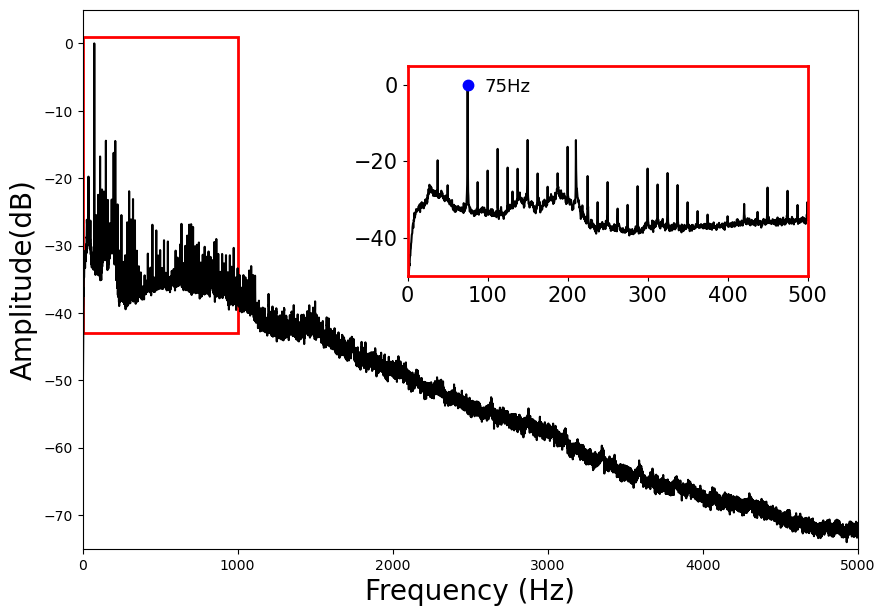

In [8]:
fig,ax = plt.subplots(figsize=(10,7))
plt.rcParams.update({'font.size': 15})

ax.plot(FREC,FFT,color='black')
ax.set_xlabel('Frequency (Hz)',fontsize=20)
ax.set_ylabel('Amplitude(dB)',fontsize=20)
ax.set_ylim((-75,5))
ax.set_xlim((0,5000))
plt.savefig('espectro_dB.png', format='png', dpi=600)

ax_zoom = fig.add_subplot()
ax_zoom.plot(FREC,FFT,color='black')
ax_zoom.set_ylim((-50,5))
ax_zoom.set_xlim((0,500))
ax_zoom.set_position([0.45,0.5,0.4,0.3])
# ax_zoom.set_edgecolor('r')
ax_zoom.spines['bottom'].set_color('red')
ax_zoom.spines['top'].set_color('red')
ax_zoom.spines['left'].set_color('red')
ax_zoom.spines['right'].set_color('red')
# change all spines
for axis in ['top','bottom','left','right'] :
    ax_zoom.spines[axis].set_linewidth(2)

ax_zoom.plot(75,0, '.', color='Blue', markersize=15)
ax_zoom.text(0.25, 0.9, '75Hz', horizontalalignment='center', verticalalignment='center', transform=ax_zoom.transAxes, fontsize=13)

#--
rectangulo = plt.Rectangle(xy=(0.001,0.4), width=0.2, height=0.55, facecolor='white', edgecolor='Red', linewidth = 2, transform=ax.transAxes)
ax.add_patch(rectangulo)

In the figure above you can see that the main frequency is close to 75Hz. We will use this frequency as the target in the detection

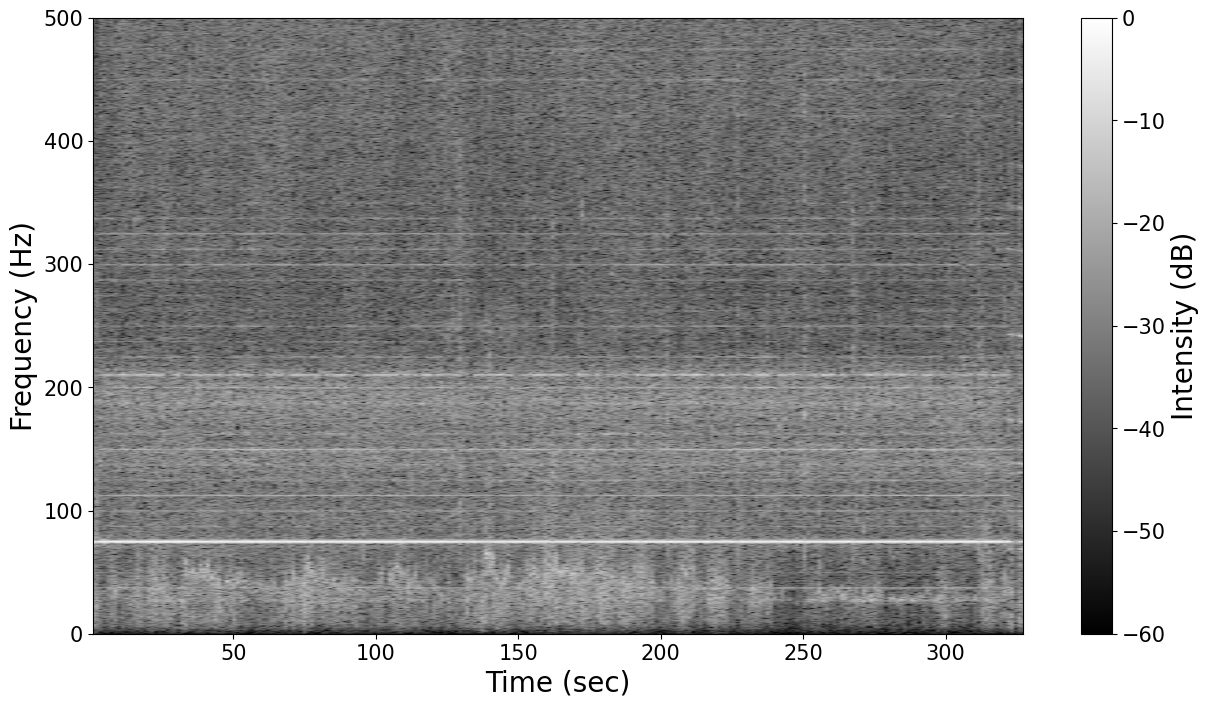

In [10]:
# ----Spectrogram ----

frec_espect, t_espect, Sxx = signal.spectrogram(data, samplerate,nperseg=2**16)
Sxx_dB = 10*np.log10(Sxx/np.max(Sxx)) # expres it on dB

fig2, ax2 = plt.subplots(figsize=(15,8))
sp = ax2.pcolormesh(t_espect, frec_espect, Sxx_dB, shading='gouraud',vmin=-60, vmax=0, cmap='gray')
ax2.set_ylabel('Frequency (Hz)',fontsize=20)
ax2.set_xlabel('Time (sec)',fontsize=20)
ax2.set_ylim((0,500))
c = plt.colorbar(sp, ax=ax2)
c.set_label('Intensity (dB)',fontsize=20)


In the spectrogram it's also clear that the predominant frequency for the hole audio is 75Hz apporximately, showing the stationary nature of the sounds. Also the higher harmonics of the signal can be seen. 

# Detection in the Audiomoth recordings

Here we used the 75Hz target frequency to compute for each audio a ration between the mean amplitud of a small interval around 75Hz and a large interval around 75Hz (I_{small75}>-<I_{big75}), so we have a measure of the prominance of that component. 

First we define the low-pass filter function that is apply to every recording and then a function to obtain the ratio value. 

In [11]:
import time

# Implement low pass filter
def filtro_pasabajo(data,samplerate,orden,frec_corte):
    
    b, a = signal.butter(orden,frec_corte,'low',fs=samplerate)
    data_filt = signal.lfilter(b, a, data)
    return data_filt

# Compute the prominance of 75Hz frequency amplitude
def entorno_75Hz(espectro,frecuencias,l,L): #2*l y 2*L are the total length (in points) of small and large intervals around 75Hz respectively
    frec_round = np.round(frecuencias)
    indice = np.where(frec_round==150)
    indice = indice[0][0]
    
    entorno_chico = espectro[indice-l:indice+l]
    dB_entorno_chico = np.mean(entorno_chico)    
    entorno_grande = espectro[indice-L:indice+L]
    dB_entorno_grande = np.mean(entorno_grande)
        
    diferencia = abs(abs(dB_entorno_chico) - abs(dB_entorno_grande)) 
    
    return diferencia

Next you have to download the Audiomoth recordings from the following repository: https://doi.org/10.5281/zenodo.14780840 or https://doi.org/10.5281/zenodo.14801757

The following code is to compute the ratio value (I_{small75}>-<I_{big75}) for each month of recording. 

In [13]:
#%% ******* MAIN LOOP *****
# Loop through the files to compute the desired magnitud

import os
dir_location = './Frei/January' # Put here the directory where the audio files for the desire month are located
dates = os.listdir(dir_location) # this variable contains the name of the folders in dir_location, which corresponds to the dates of the month

MAT_DIF = np.zeros((len(dates),24)) # creat a matrix with 24 columns, one for each hour of the day. The rows are the dates

for KK in range(len(dates)):
    hours = os.listdir(dir_location + '/' + dates[KK])
    
    for JJ in range(len(hours)):
        hr = hours[JJ]
        samplerate, data = wavfile.read(dir_location + '/' + dates[KK] + '/' + hr)
        
        data_filt = filtro_pasabajo(data,samplerate,10,1000) #low pass filter
        [FFT,FREC] = promedio_espectros(data_filt,samplerate,100) # split the audio into 100 intervals, compute the FFT for each and average them
        MAT_DIF[KK,JJ] = entorno_75Hz(FFT,FREC,3,50) # compute the desire magnitud I_{small75}>-<I_{big75}
        
    
    print(dates[KK]) # print for control on the code running over the desired dates

20230117
20230118
20230119
20230120
20230121
20230122
20230123
20230124
20230125
20230126
20230127
20230128
20230129
20230130
20230131


Plot the matrix with the I_{small75}>-<I_{big75} values

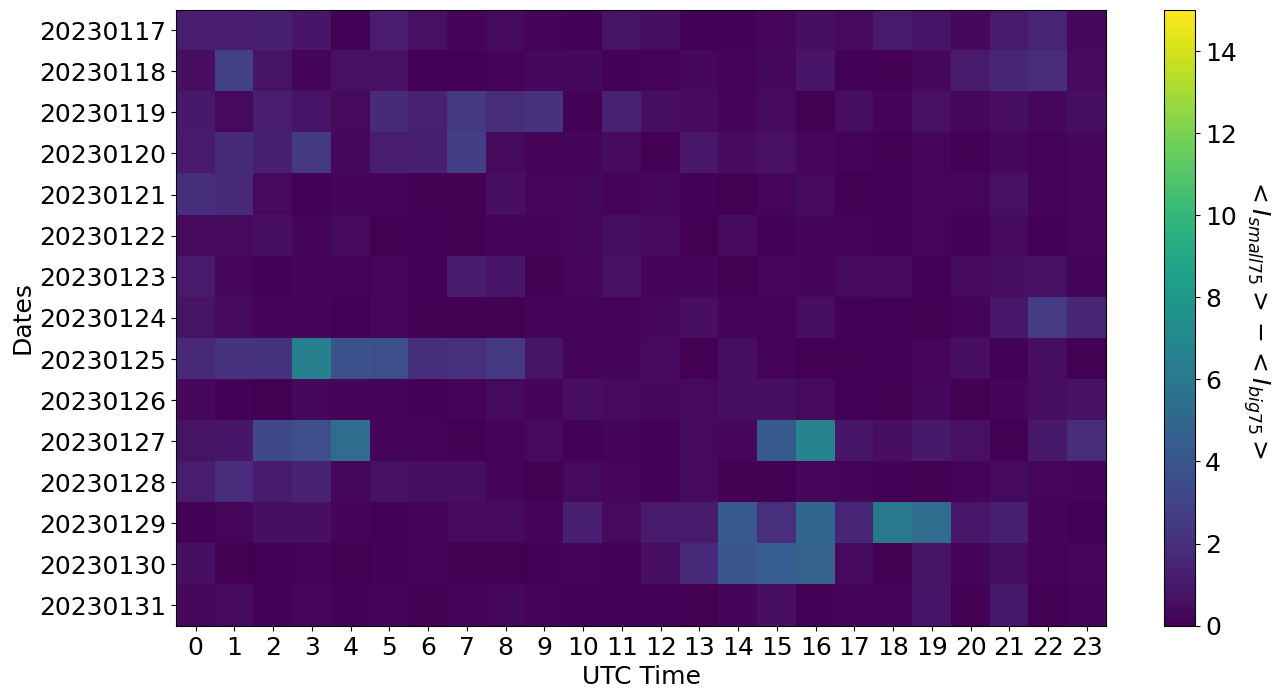

In [18]:
# ------- PLOT ------
vect_hours = np.linspace(0,23,24)
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 18})
plt.pcolor(vect_hours,np.arange(0,len(dates)),MAT_DIF)
plt.yticks(np.arange(len(dates)), dates)
plt.xticks(vect_hours)
cbar = plt.colorbar()
cbar.set_label(r'$<I_{small75}>-<I_{big75}>$', rotation=270, labelpad=25)
plt.clim(0,20)
plt.xlabel('UTC Time')
plt.ylabel('Dates')
plt.clim(0, 15)
ax = plt.gca()
ax.invert_yaxis()